# Filters
A notebook to test filter implementation for ease of converting to `C`, `C++`, or `ino` for the Arduino.

## Initial setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Real-time peak detection (with drifting baseline)

### Create noisy signal

In [27]:
# Raw signal
T = 1000
y = np.zeros(T)

# Add noise (assume N(0, 1))
y += np.random.randn(T)

# Add peaks (assume N(SNR, 0))
SNR = 3.0
dt_signal = 5
n_signal = 10
t_signal = np.random.randint(int(0.10*T), int(min(0.9*T, T-dt_signal)), size=n_signal)
t_signal = (t_signal[:, np.newaxis] + (np.arange(dt_signal)+1)[np.newaxis, :]).flatten()
y[t_signal] += SNR

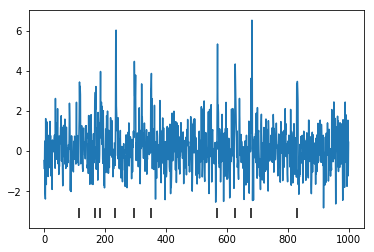

In [28]:
# Plot noisy signal
plt.plot(y)
plt.vlines(t_signal[::dt_signal], ymin=np.min(y)-0.5, ymax=np.min(y))

### Apply real-time filter
Since we are mimicking real-time, we will feed values one at a time. We will also keep in mind that we need to adapt this code to `C`, so we can't get too fancy with indexing or higher-level structures. 

Credit: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

In [ ]:
# Filter settings
n_filt = 10 # length of filter

# Initialize buffers
y_filt = 

for t in range(T):
    if t 